# Importações

In [1]:
import os
import shutil
import random
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Instalar YOLOV5

In [1]:
!git clone https://github.com/ArtBreguez/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9469, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9469 (delta 2), reused 8 (delta 2), pack-reused 9460
Receiving objects: 100% (9469/9469), 11.75 MiB | 15.96 MiB/s, done.
Resolving deltas: 100% (6324/6324), done.
/tmp/tcc_alpd/yolov5/yolov5


In [2]:
!pip install -r requirements.txt

In [3]:
import utils
display = utils.notebook_init()

YOLOv5 🚀 254aef3 Python-3.8.18 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2080, 7967MiB)


Setup complete ✅ (6 CPUs, 31.2 GB RAM, 158.5/914.8 GB disk)


# Preparar Dataset

In [5]:
!curl -L -o /tmp/tcc_alpd/archive.tar.gz "https://www.dropbox.com/scl/fi/khnnv0x8pcpbzlgfevqac/archive.tar.gz?rlkey=55w3pkxp02szjpqw22df7hmn8&dl=0"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    179      0 --:--:--  0:00:01 --:--:--   179
100   491    0   491    0     0    184      0 --:--:--  0:00:02 --:--:--     0
100  202M  100  202M    0     0  12.6M      0  0:00:16  0:00:16 --:--:-- 15.9M


In [6]:
!tar xfv /tmp/tcc_alpd/archive.tar.gz -C /tmp/tcc_alpd

archive/
archive/.DS_Store
archive/images/
archive/annotations/
archive/annotations/Cars213.xml
archive/annotations/Cars207.xml
archive/annotations/Cars398.xml
archive/annotations/Cars367.xml
archive/annotations/Cars401.xml
archive/annotations/Cars415.xml
archive/annotations/Cars373.xml
archive/annotations/Cars429.xml
archive/annotations/Cars47.xml
archive/annotations/Cars53.xml
archive/annotations/Cars165.xml
archive/annotations/Cars171.xml
archive/annotations/Cars159.xml
archive/annotations/Cars84.xml
archive/annotations/Cars90.xml
archive/annotations/Cars91.xml
archive/annotations/Cars85.xml
archive/annotations/Cars158.xml
archive/annotations/Cars170.xml
archive/annotations/Cars164.xml
archive/annotations/Cars52.xml
archive/annotations/Cars46.xml
archive/annotations/Cars428.xml
archive/annotations/Cars414.xml
archive/annotations/Cars372.xml
archive/annotations/Cars366.xml
archive/annotations/Cars400.xml
archive/annotations/Cars399.xml
archive/annotations/Cars206.xml
archive/annotati

In [7]:
IMAGE_PATH = "/tmp/tcc_alpd/archive/images"
ANNOTATIONS_PATH = "/tmp/tcc_alpd/archive/annotations"

DATASET_PATH = "Dataset/"
TRAIN_LABELS_PATH = "train/labels"
VAL_LABELS_PATH = "val/labels"
TRAIN_IMAGES_PATH = DATASET_PATH+"train/images"
VAL_IMAGES_PATH = DATASET_PATH+"val/images"

In [8]:
def split_dataset(source_dir, train_dir, val_dir, val_percentage=0.2):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(train_dir+"/labels", exist_ok=True)
    os.makedirs(val_dir+"/labels", exist_ok=True)
    os.makedirs(train_dir+"/images", exist_ok=True)
    os.makedirs(val_dir+"/images", exist_ok=True)

    files = os.listdir(source_dir)
    random.shuffle(files)

    num_val_files = int(len(files) * val_percentage)

    for i, file in enumerate(files):
        source_file = os.path.join(source_dir, file)
        if i < num_val_files:
            shutil.copy(source_file, os.path.join(val_dir, file))
        else:
            shutil.copy(source_file, os.path.join(train_dir, file))

In [9]:
split_dataset(IMAGE_PATH, DATASET_PATH+"train", DATASET_PATH+"val")

# Convertendo Labels para o formato YOLOV5


In [14]:
def convert_coordinates(size, box):
    x1, y1, x2, y2 = map(int, box)
    dw = np.float32(1.0 / int(size[0]))
    dh = np.float32(1.0 / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x_center = x1 + (w / 2)
    y_center = y1 + (h / 2)

    x_center *= dw
    w *= dw
    y_center *= dh
    h *= dh
    return [x_center, y_center, w, h]

def save_annotations(img_jpg_file_name, size, img_boxes, labels_path):
    classes = ['license']
    save_file_name = f"{DATASET_PATH}/{labels_path}/{img_jpg_file_name}.txt"
    
    with open(save_file_name, "a+") as file_path:
        for box in img_boxes:
            cls_num = 0
            new_box = convert_coordinates(size, box[1:])
            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

def parse_xml(file_path, img_xml_file, labels_path):
    img_path = f"{file_path}/{img_xml_file}.xml"
    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    img_boxes = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        img_jpg_file_name = f"{img_xml_file}.jpg"
        img_boxes.append([cls_name, x1, y1, x2, y2])
    save_annotations(img_xml_file, [img_w, img_h], img_boxes, labels_path)

def process_files(annotations_path, train_val_dir, labels_path, images_path):
    xml_files = [f for f in os.listdir(annotations_path) if f.endswith('.xml')]
    files = [f.split('.')[0] for f in os.listdir(train_val_dir) if f.endswith('.png')]
    
    for xml_file in xml_files:
        xml_name = xml_file.split('.')[0]
        if xml_name in files:
            parse_xml(annotations_path, xml_name, labels_path)
            src_path = os.path.join(train_val_dir, f"{xml_name}.png")
            dest_path = os.path.join(images_path, f"{xml_name}.png")
            shutil.move(src_path, dest_path)

In [15]:
process_files(ANNOTATIONS_PATH, DATASET_PATH+"train", TRAIN_LABELS_PATH, TRAIN_IMAGES_PATH)
process_files(ANNOTATIONS_PATH, DATASET_PATH+"val", VAL_LABELS_PATH, VAL_IMAGES_PATH)

# YOLOV5 treinamento


In [16]:
!python train.py --img 416 --batch 16 --epochs 50 --data data/alpr.yaml --cfg models/yolov5s.yaml

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/alpr.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ArtBreguez/yolov5 ✅
YOLOv5 🚀 254aef3 Python-3.8.18 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2080, 7967MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015

# Analise de resultados

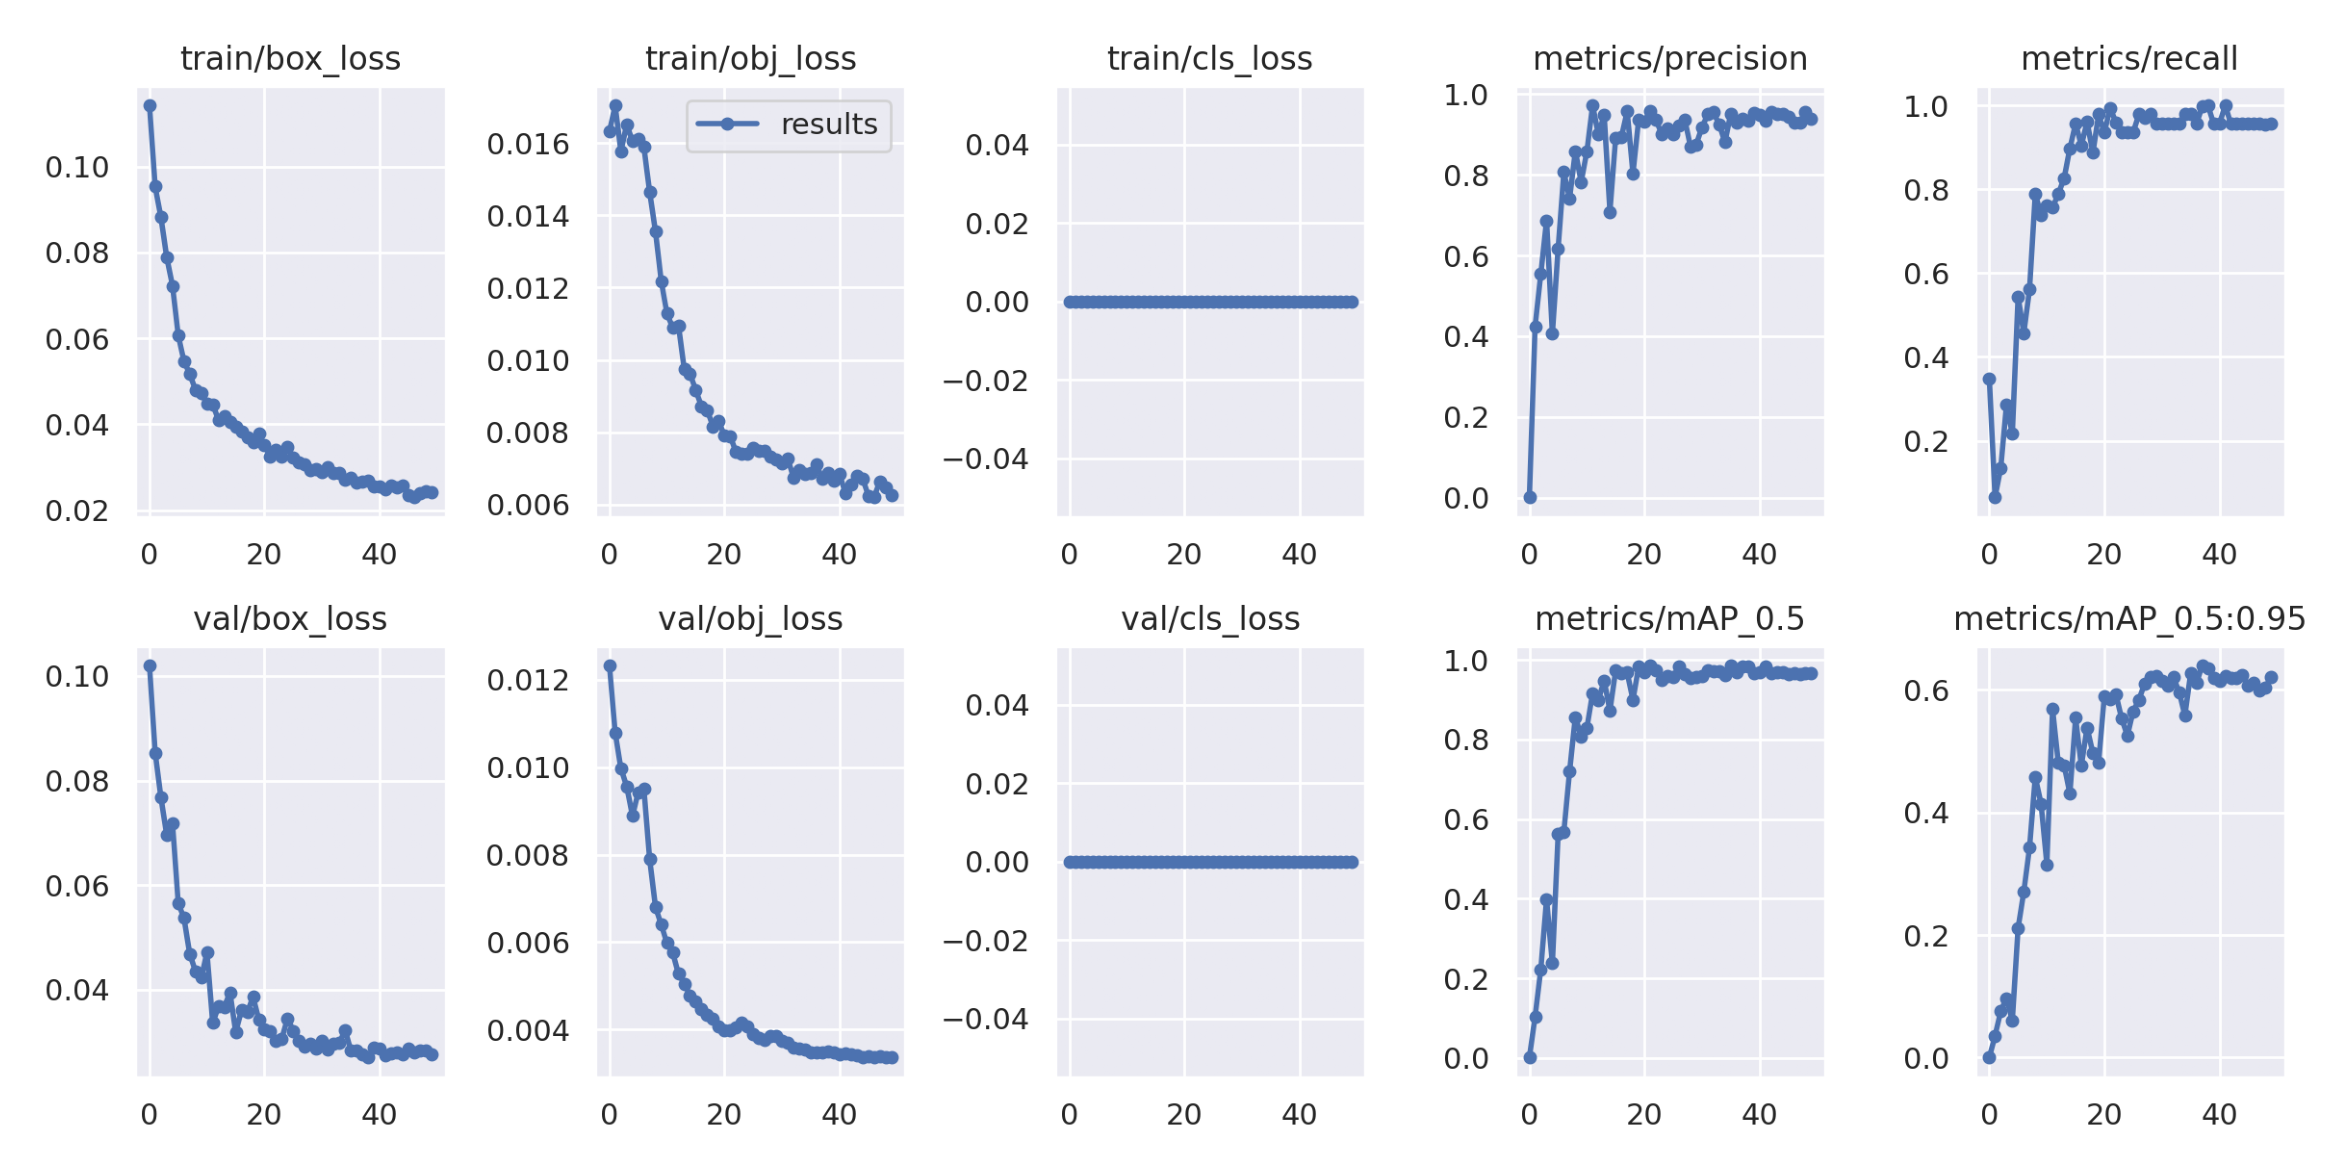

In [17]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'))

In [18]:
# validação
!python val.py --weights 'runs/train/exp/weights/best.pt' --img 416 --batch 64 --data data/alpr.yaml --project 'alpr' --name 'validation_on_test_data' --augment

val: data=data/alpr.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=64, imgsz=416, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=alpr, name=validation_on_test_data, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 254aef3 Python-3.8.18 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2080, 7967MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/tmp/tcc_alpd/yolov5/yolov5/Dataset/val/labels.cache' images and 
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         43         46      0.916      0.954      0.982      0.643
Speed: 0.7ms pre-process, 5.4ms inference, 2.9ms NMS per image at shape (64, 3, 416, 416)
Results saved to alpr/validation_on_test_data


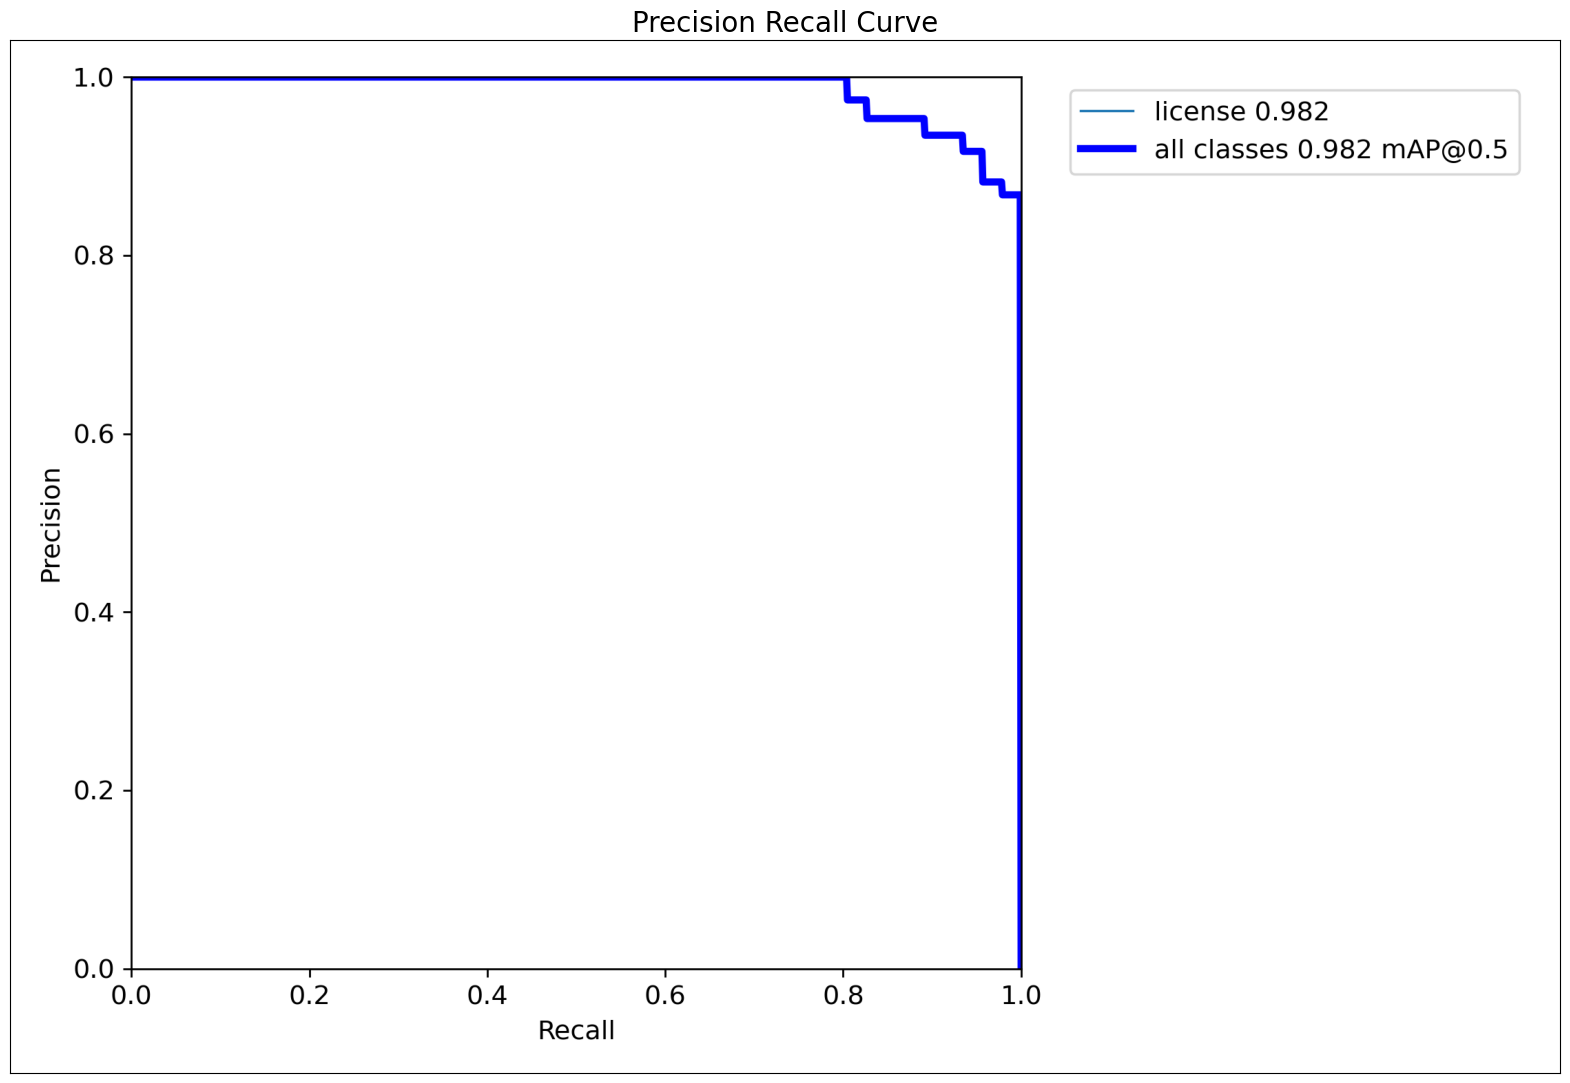

In [19]:
plt.figure(figsize=(20, 20))
imagem = mpimg.imread('alpr/validation_on_test_data/PR_curve.png')
plt.imshow(imagem, extent=[0, imagem.shape[1], 0, imagem.shape[0]])
plt.title('Precision Recall Curve', fontsize=20)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

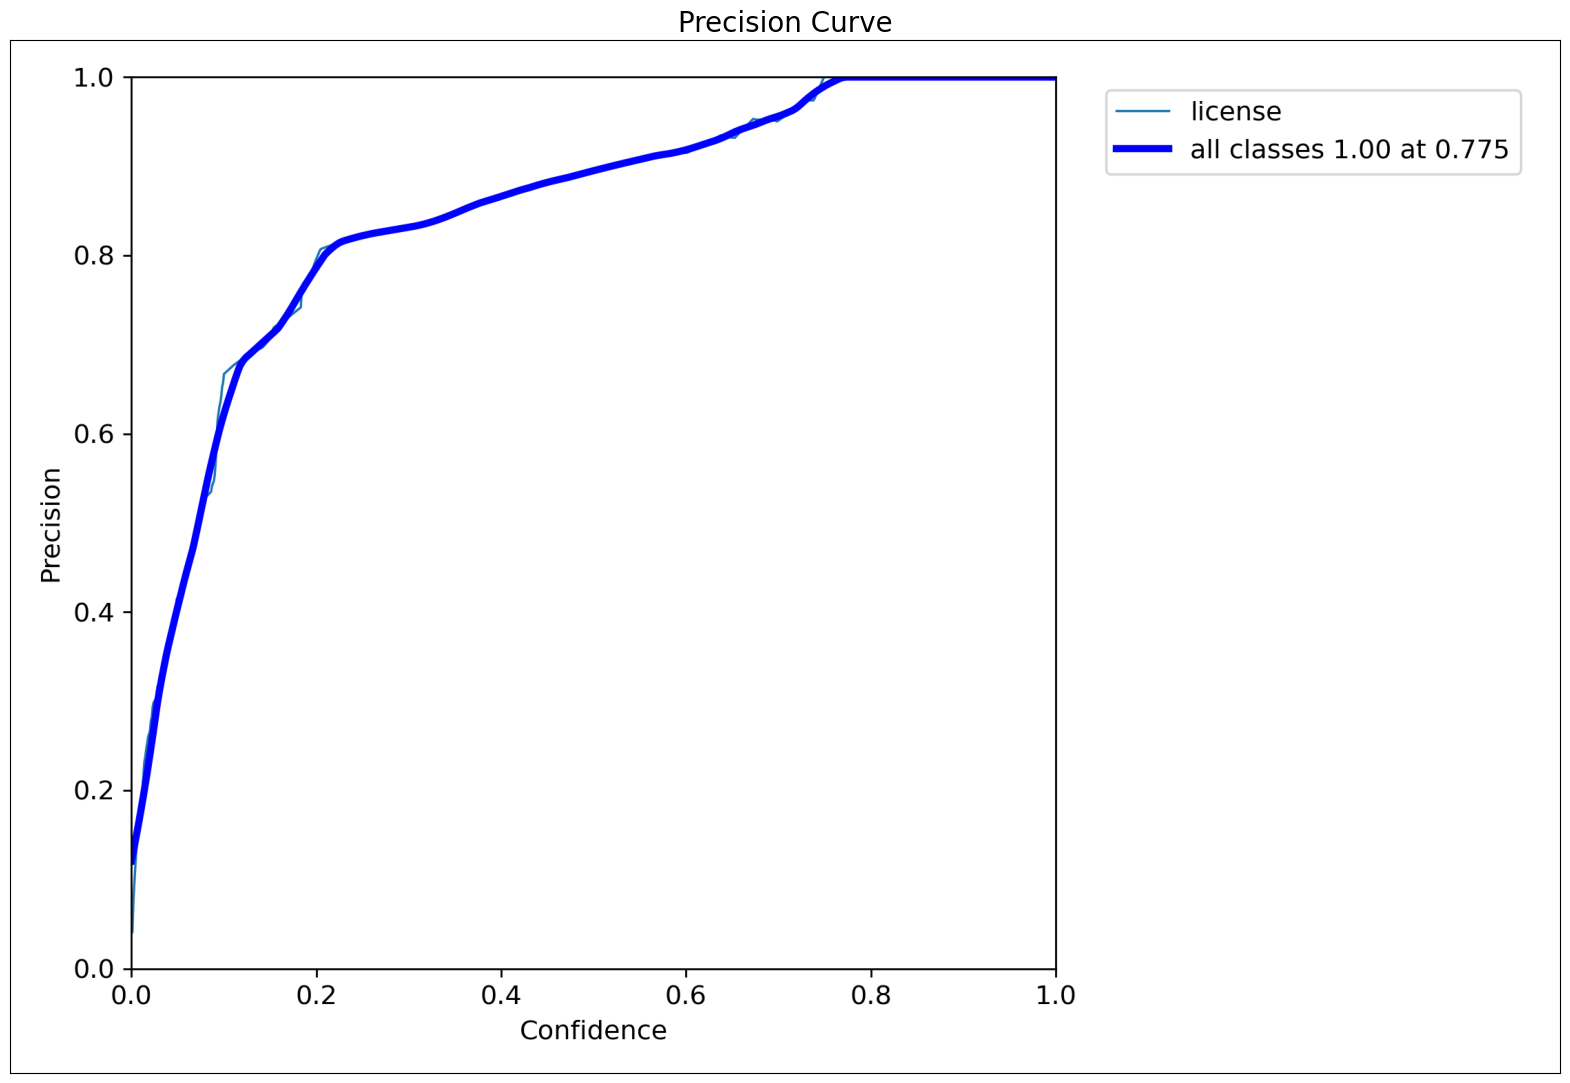

In [20]:
plt.figure(figsize=(20, 20))
imagem = mpimg.imread('alpr/validation_on_test_data/P_curve.png')
plt.imshow(imagem, extent=[0, imagem.shape[1], 0, imagem.shape[0]])
plt.title('Precision Curve', fontsize=20)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

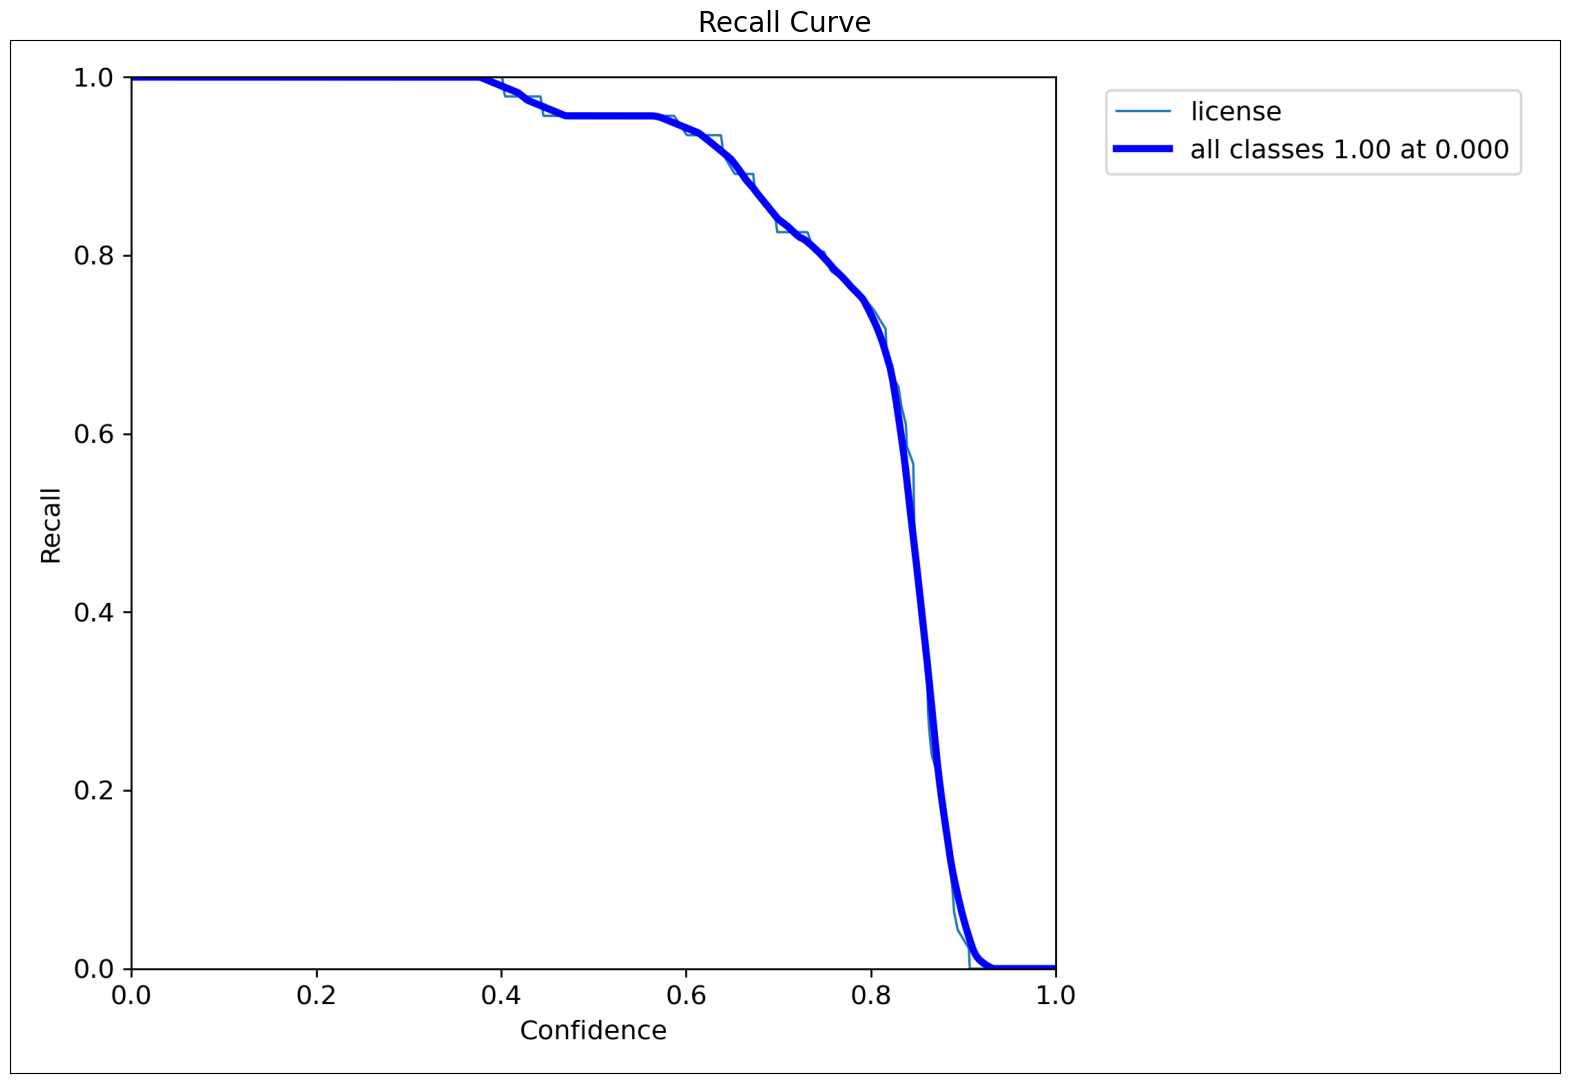

In [21]:
plt.figure(figsize=(20, 20))
imagem = mpimg.imread('alpr/validation_on_test_data/R_curve.png')
plt.imshow(imagem, extent=[0, imagem.shape[1], 0, imagem.shape[0]])
plt.title('Recall Curve', fontsize=20)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

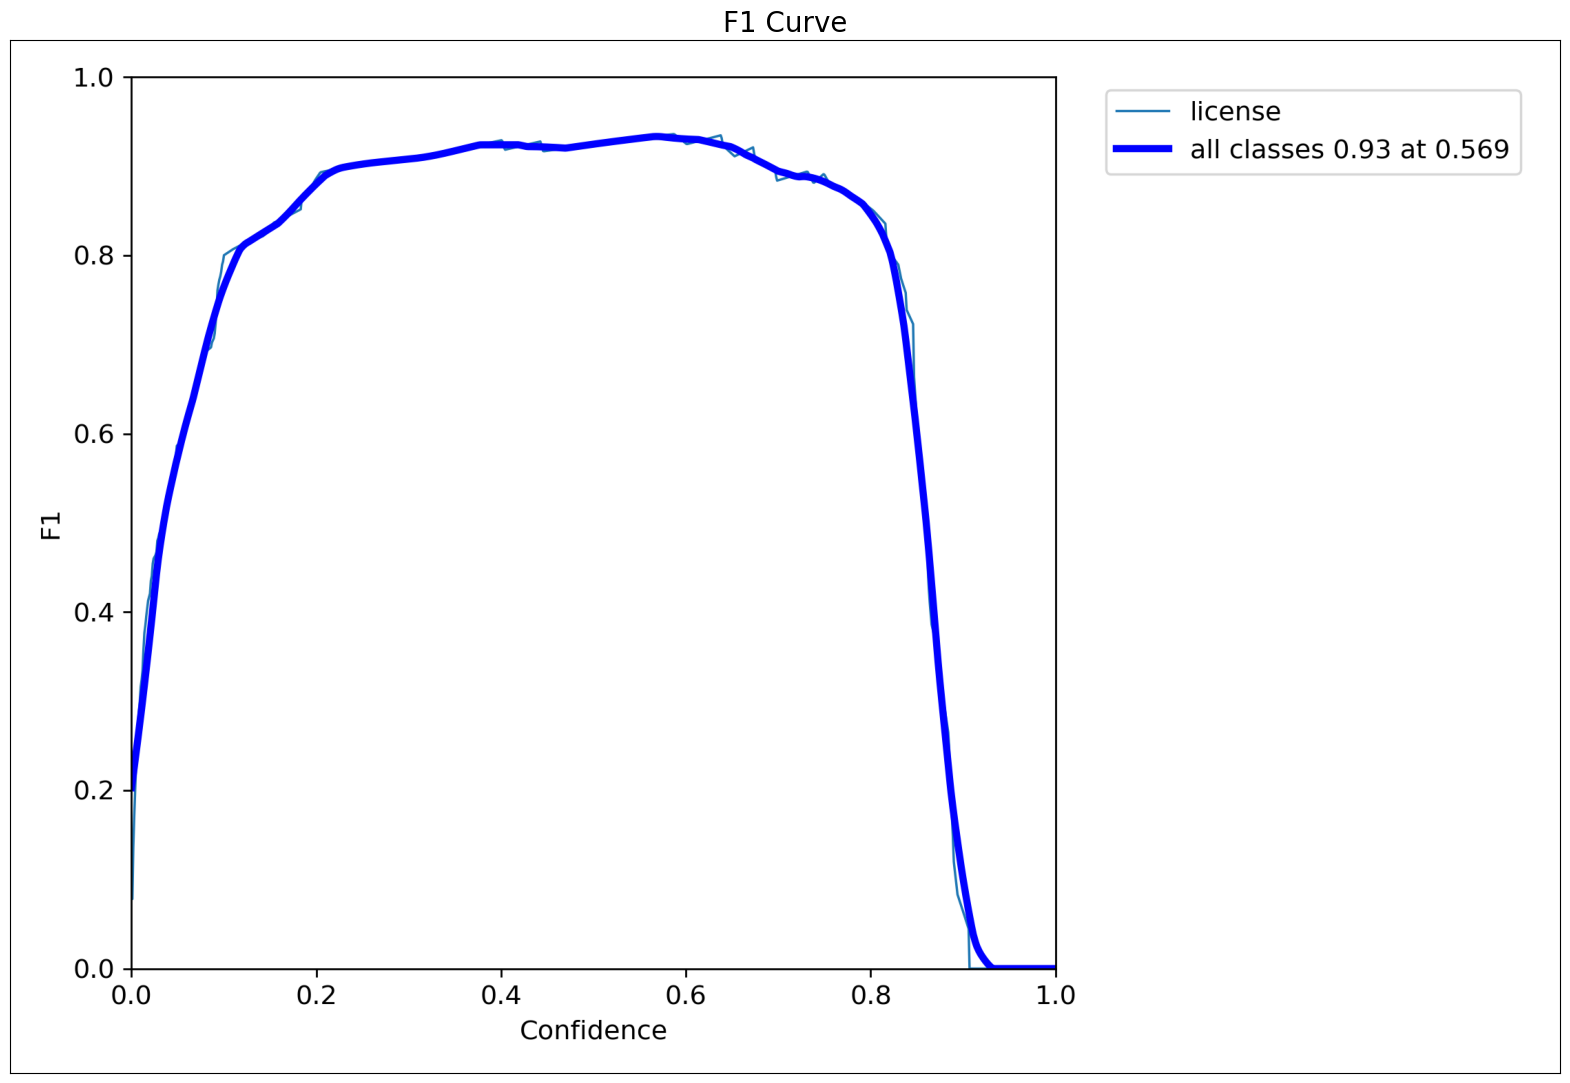

In [22]:
plt.figure(figsize=(20, 20))
imagem = mpimg.imread('alpr/validation_on_test_data/F1_curve.png')
plt.imshow(imagem, extent=[0, imagem.shape[1], 0, imagem.shape[0]])
plt.title('F1 Curve', fontsize=20)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

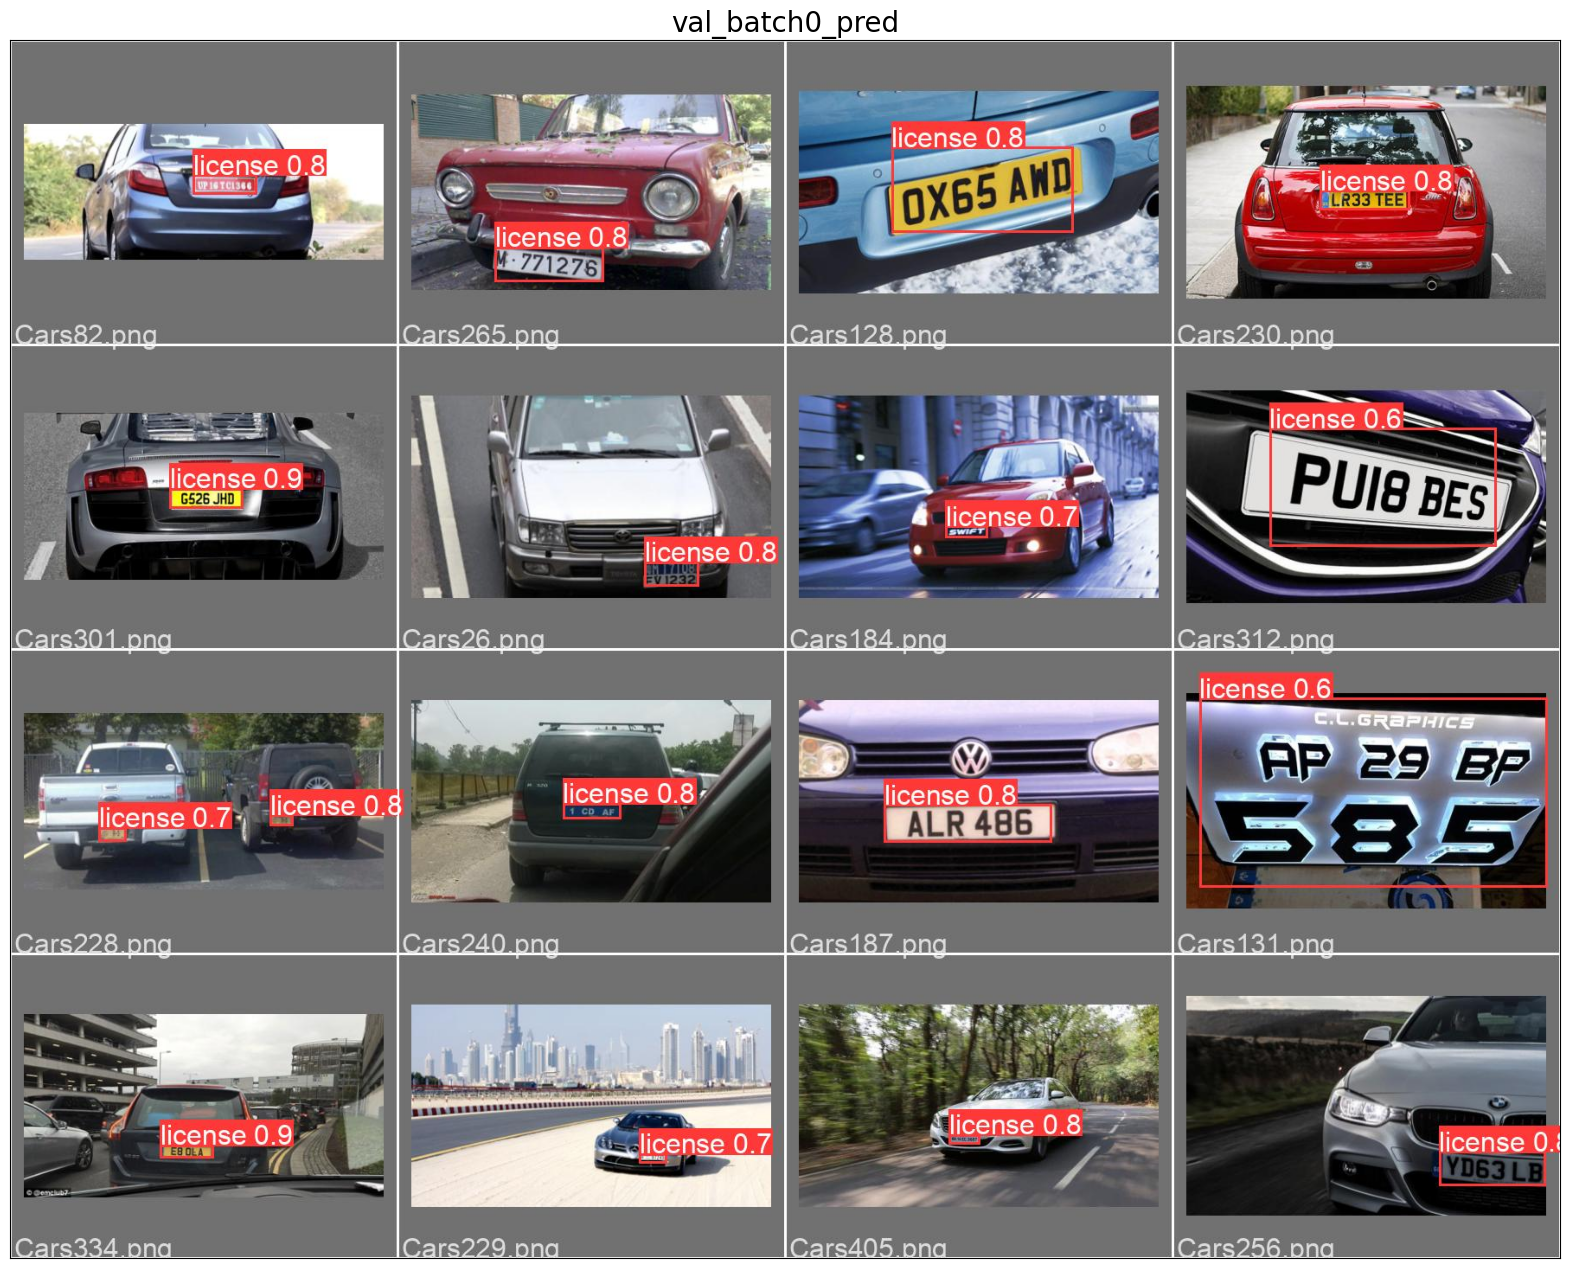

In [25]:
plt.figure(figsize=(20, 20))
imagem = mpimg.imread('runs/train/exp/val_batch0_pred.jpg')
plt.imshow(imagem, extent=[0, imagem.shape[1], 0, imagem.shape[0]])
plt.title('val_batch0_pred', fontsize=20)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

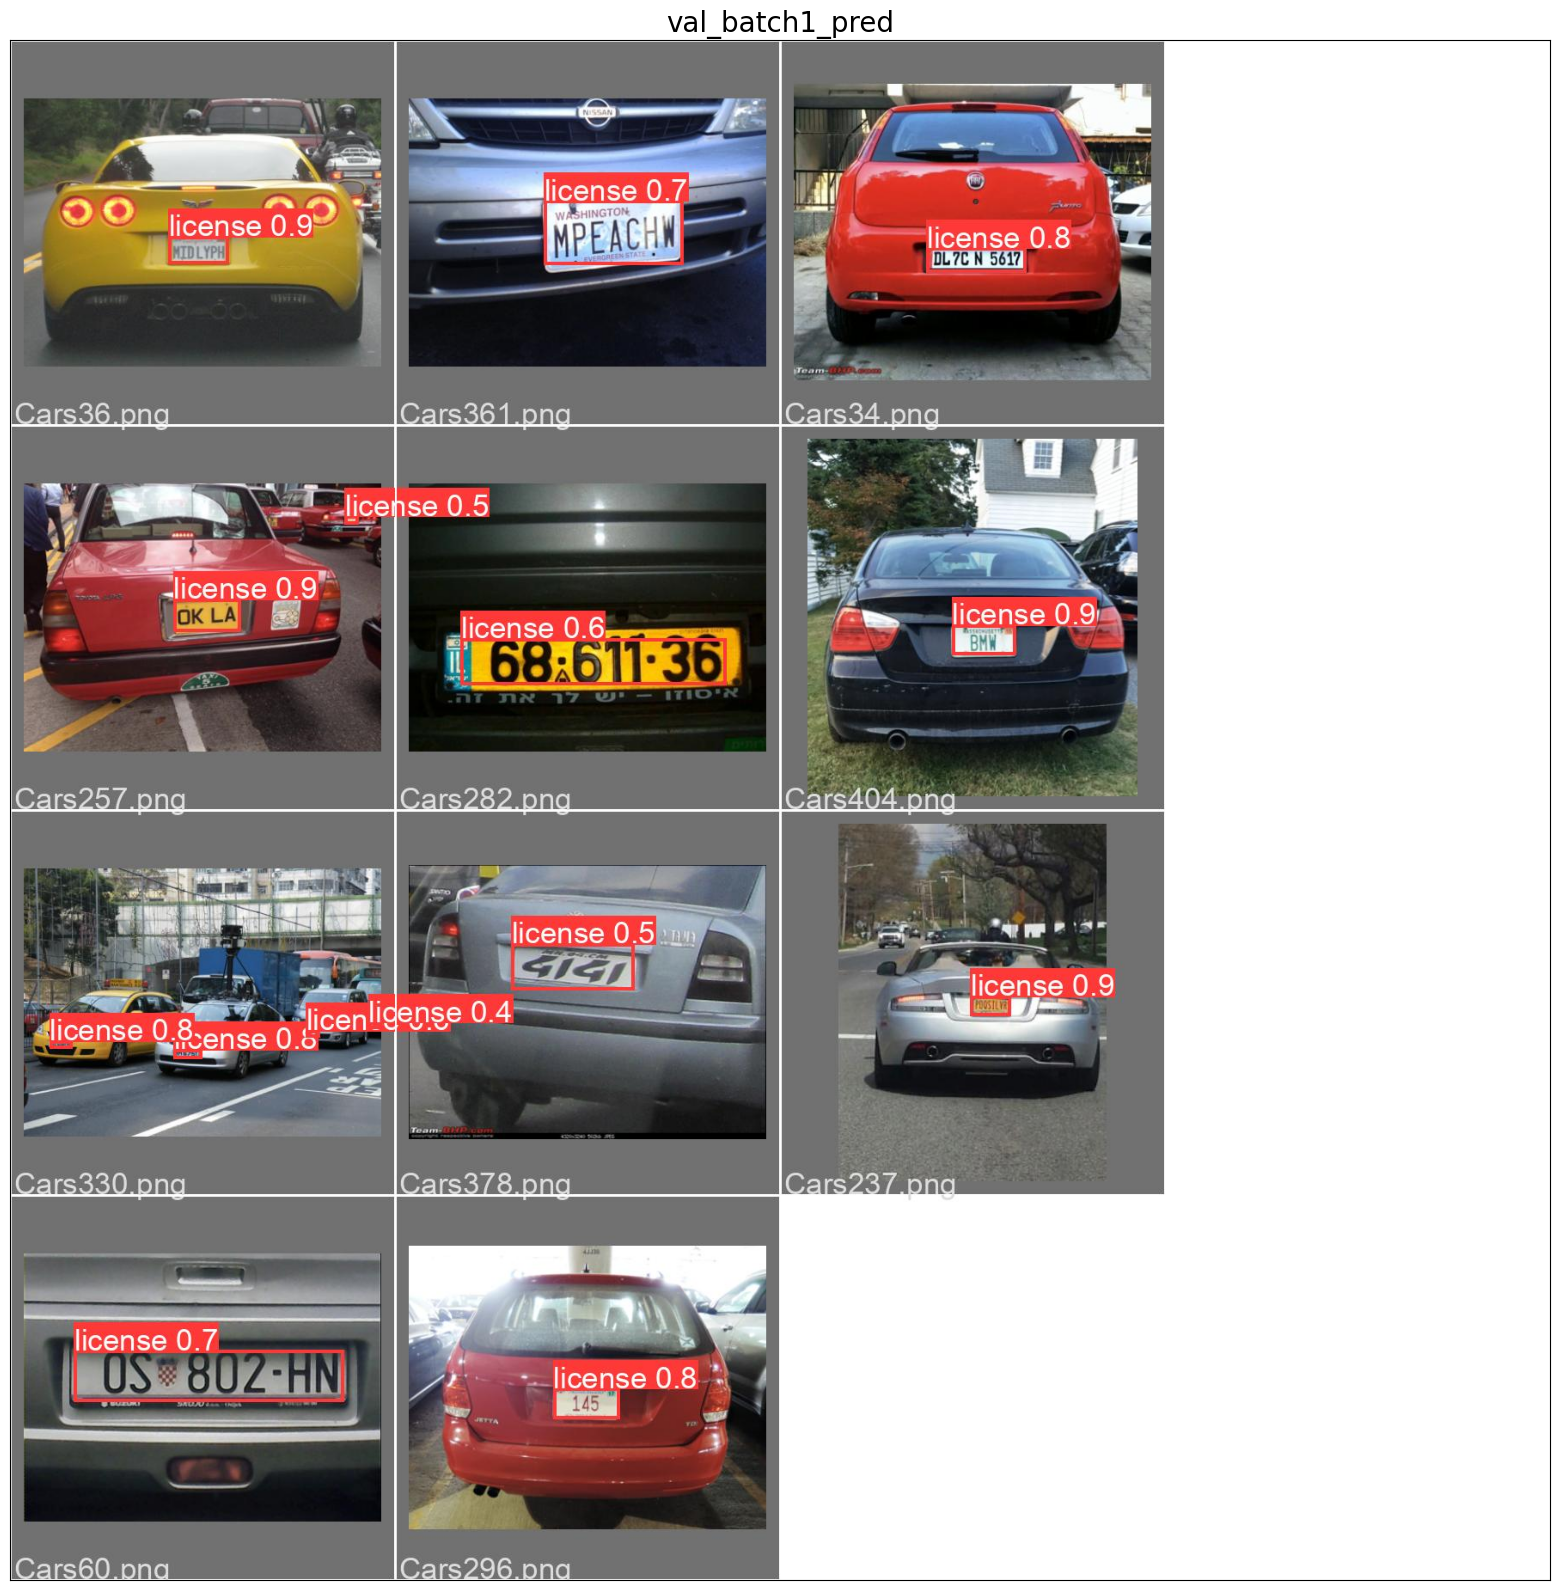

In [27]:
plt.figure(figsize=(20, 20))
imagem = mpimg.imread('runs/train/exp/val_batch1_pred.jpg')
plt.imshow(imagem, extent=[0, imagem.shape[1], 0, imagem.shape[0]])
plt.title('val_batch1_pred', fontsize=20)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()